# Extracting C19 American literature records from Library of Congress books

1. Download the [MDSConnect "Books All" 2019 dataset](https://lccn.loc.gov/2020445551) from the Library of Congress. (This is the most current as of 2024-06-25.)
2. Extract the archive.
3. Fill the path on your system to the directory `2020445551_2019` in the variable `BASE` below.
4. Run the cells below to regnerate results.

In [1]:
from bs4 import BeautifulSoup
import gc
import gzip
import io
import os
import pandas as pd
import pickle
import re
import string
import time
import xml.etree.ElementTree as ET

In [2]:
BASE = "/Users/erik/Documents/Corpora/Library of Congress Books All MARC records/2020445551_2019"

In [3]:
def get_xml_gzs(path):
    """Gets all of the xml.gz files in MDSConnect excluding the combined files, which duplicate records."""
    return [
        os.path.join(path, x)
        for x in os.listdir(path)
        if x.endswith(".xml.gz") and "combined" not in x
    ]

In [4]:
xml_gzs = get_xml_gzs(BASE)
# this should return 46:
len(xml_gzs)

46

# Extraction functions

The following functions extract data from the MARC records in a way that will be suitable for a tabular data structure.

The calls to `extract_subfield` can be customized to get any subfield the user wishes.

For information on what is contained within these fields, see the [LC format for MARC bibliographic data](https://www.loc.gov/marc/bibliographic/).

For example, [here is the section explaining the fields pertaining to place of publication](https://www.loc.gov/marc/bibliographic/bd260.html).

In [5]:
def open_gzip_file(file_path):
    """
    Function to open a gzipped file and return an iterator over its lines.
    """
    return gzip.open(file_path, "rt", encoding="utf-8")


def parse_records(file_path):
    """
    Generator function to parse records from a gzipped XML file.
    """
    with open_gzip_file(file_path) as f:
        context = ET.iterparse(f, events=("end",))
        for event, elem in context:
            if elem.tag == "{http://www.loc.gov/MARC21/slim}record":
                yield elem


def extract_subfields(record, tag, subfield_code, ns):
    """
    Extract subfield values for a given tag and subfield code.
    """
    return [
        subfield.text
        for subfield in record.findall(
            f'marc:datafield[@tag="{tag}"]/marc:subfield[@code="{subfield_code}"]', ns
        )
    ]


def process_record(record):
    """
    Function to process each <record> element.
    """
    ns = {"marc": "http://www.loc.gov/MARC21/slim"}
    classifications = extract_subfields(record, "050", "a", ns)
    if not classifications:
        return None

    # Only retain PS records
    if not any(
        str(classification).startswith("PS") for classification in classifications
    ):
        return None

    # Extract data from the <record> element
    lccn = extract_subfields(record, "010", "a", ns)
    personal_name_100 = extract_subfields(record, "100", "a", ns)
    title = extract_subfields(record, "245", "a", ns)
    years_260 = extract_subfields(record, "260", "c", ns)
    years_264 = extract_subfields(record, "264", "c", ns)
    places_260 = extract_subfields(record, "260", "a", ns)
    publisher_260 = extract_subfields(record, "260", "b", ns)
    places_264 = extract_subfields(record, "264", "a", ns)

    # Combine years and places
    years = list(set(years_260 + years_264))
    places = list(set(places_260 + places_264))

    data = {
        "lccn": lccn if lccn else None,
        "classifications": classifications,
        "title": title[0] if title else None,
        "year": years,
        "places": places,
        "publishers": publisher_260,
        "first_author": personal_name_100[0] if personal_name_100 else None,
    }
    return data


def process_files(file_paths, output_dir):
    """
    Function to process multiple gzipped XML files and save extracted data as pickles iteratively.
    """
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    total_files = len(file_paths)
    for i, file_path in enumerate(file_paths, 1):
        start_time = time.time()
        all_data = []
        for record in parse_records(file_path):
            data = process_record(record)
            if data:  # Only append data if it passed the filter
                all_data.append(data)

        # Generate a unique filename based on the input file name
        output_file = (
            f"{output_dir}/{os.path.basename(file_path).replace('.xml.gz', '')}.pkl"
        )

        # Write the collected data to a pickle file
        with open(output_file, "wb") as f:
            pickle.dump(all_data, f)

        # Print progress
        print(
            f"Processed {i}/{total_files} files: {file_path} written to {output_file}"
        )
        print(f"Time elapsed: {time.time() - start_time:.2f} seconds")

        del all_data
        gc.collect()


def load_pickles_to_dataframe(pickle_dir):
    """
    Load all pickle files from the specified directory into a single DataFrame.

    Parameters:
    pickle_dir (str): The directory containing the pickle files.

    Returns:
    pd.DataFrame: A DataFrame containing the concatenated data from all pickle files.
    """
    all_data = []

    for file_name in os.listdir(pickle_dir):
        if file_name.endswith(".pkl"):
            file_path = os.path.join(pickle_dir, file_name)
            with open(file_path, "rb") as f:
                data = pickle.load(f)
                all_data.extend(data)  # Extend the list with data from each pickle file

    # Convert the combined data into a DataFrame
    df = pd.DataFrame(all_data)
    return df

In [6]:
# This cell runs the functions above and pickles the results.
# It takes about 45 minutes to run on an M1 MacBook Air.

# Update output_dir with the path you want to use on your machine
output_dir = "/Users/erik/Desktop/LC_PS"

# Uncomment the line below to process the files and collect data
# process_files(xml_gzs, output_dir)

In [7]:
# After running the above, load the pickled results into a data frame:

df = load_pickles_to_dataframe(output_dir)
df.head()

,lccn,classifications,title,year,places,publishers,first_author
0,[ 99023169 ],[PS3573.O693],Mulroney & others :,[c2000.],"[Louisville, Ky. :]","[Sarabande Books,]","Wormser, Baron."
1,[ 99023173 ],[PS3535.O5396],Fortune and misery :,[c1999.],[Baton Rouge :],"[Louisiana State University Press,]","Roman, Sallie Rhett,"
2,[ 99023176 ],[PS2025],A modern instance /,[c2000.],"[New Brunswick, NJ :]","[Transaction Publishers,]","Howells, William Dean,"
3,[ 99023183 ],[PS2127.E8],Henry James and modern moral life /,[2000.],"[Cambridge ;, New York :]","[Cambridge University Press,]","Pippin, Robert B.,"
4,[ 99023197 ],[PS3573.E354],Putting the amazing back in grace /,[c1999.],"[Louisville, Ky. :]","[Westminster John Knox Press,]","Weems, Ann,"


# Cleaning the results

- Extract the `PS` range for American literature
  - See the [LC Classification Outline](https://www.loc.gov/aba/cataloging/classification/lcco/) for information about specific ranges
- Filter `PS` range for American literature (`PS` includes Canadian lit, too)
- Get publication years and `PS` lead digits as integers for sorting
- Clean places of publication

In [8]:
def get_ps_digits(classification):
    """
    Extract the digits following the PS prefix in the classification.
    """
    match = re.search(r"PS(.*)", classification)
    if match:
        s = match.group(1).strip()
    # drop any remaining letters; only retain numbers
    try:
        if "." in s:
            return int(s.split(".")[0].strip())
        elif " " in s:
            return int(s.split(" ")[0].strip())
        else:
            return int(classification.split("PS")[-1].split(".")[0].strip())
    except:
        return None

In [9]:
def get_ps_digits(classification):
    """
    Extract digits immediately following "PS" up to but not including the first non-numeric character,
    or until the end of the string if no non-numeric character follows.
    """
    match = re.search(r"PS(\d+)(?=[^\d]|$)", classification)
    if match:
        return int(match.group(1))
    else:
        return None

In [10]:
df["ps_digits"] = df["classifications"].apply(
    lambda x: [get_ps_digits(y) for y in x if "PS" in y][0]
)

In [11]:
# Canadian literature gets the upper end of the PS subclass, and is excluded from this analysis.
# PS(8001-8599) == Canadian literature
df["is_canadian"] = df["ps_digits"] > 8000

In [12]:
# Drop Canadian records
df = df[~df["is_canadian"]]

In [13]:
def get_year_int(year):
    """
    Function to extract the year as an integer from the year column.
    """
    match = re.search(r"\d{4}", year)
    return int(match.group()) if match else None

In [14]:
def get_years_ints(year):
    if type(year) is str:
        return get_year_int(year)
    # Resolve cases with multiple years to the earliest year:
    elif type(year) is list:
        y_temp = [get_year_int(y) for y in year]
        y_temp = [y for y in y_temp if y is not None]
        if y_temp:
            return min(y_temp)
        else:
            return None

In [15]:
def get_publishers_year_ints(publishers):
    """Rarely, LC records include publication year in the publisher field.
    Get year-like values from publishers, and take the minimum value."""
    if type(publishers) is str:
        publishers = [publishers]
    try:
        return min([get_year_int(p) for p in publishers if get_year_int(p) is not None])
    except ValueError:
        return None

In [16]:
df["year_int"] = df["year"].apply(get_years_ints)

In [17]:
df["publisher_year_int"] = df["publishers"].apply(get_publishers_year_ints)

In [18]:
# combine_first integers from publishers and year columns
df["year_publisher_int"] = df["year_int"].combine_first(df["publisher_year_int"])

In [19]:
# return the min value between two columns
def get_min_year(row):
    return min(row["year_publisher_int"], row["publisher_year_int"])

In [20]:
df["min_year"] = df.apply(get_min_year, axis=1)

In [21]:
# Fill missing values with min year 0
df["min_year"] = df["min_year"].fillna(0).astype(int)

In [22]:
def clean_col(df, col):
    return df[col].apply(lambda x: x[0] if len(x) == 1 else x)

In [23]:
# clean up place names
def clean_string(s):

    if s is None:
        return None

    # Remove whitespace from the end of the string
    s = s.rstrip()

    # Remove punctuation from the end of the string
    while s and (s[-1] in string.punctuation or s[-1].isspace()):
        s = s[:-1]

    return s

In [24]:
df["places_clean"] = df["places"].apply(lambda x: [clean_string(s) for s in x])

In [25]:
cols = ["lccn", "classifications", "year", "places", "publishers"]
for col in cols:
    df[col] = clean_col(df, col)

In [26]:
def get_decade(year):
    """
    Function to extract the decade from a year.
    """
    if year > 0:
        return year // 10 * 10

In [27]:
df["decade"] = df["min_year"].apply(get_decade)

In [28]:
# Creating the C19 data frame including some cleaned values:

df_c19 = df.copy()
df_c19 = df_c19[
    [
        "lccn",
        "classifications",
        "ps_digits",
        "first_author",
        "title",
        "year",
        "min_year",
        "publishers",
        "places",
    ]
]
df_c19 = df_c19[df_c19["min_year"] <= 1945]

In [29]:
# Examples records with missing integer years:
df_c19[df_c19["min_year"] == 0].sample(5)

,lccn,classifications,ps_digits,first_author,title,year,min_year,publishers,places
250725,2005544057,PS3618.O25,3618.0,"Roach, Irene.",Continuum -- continuum -- continuum.,[199?],0,"Urchin Press,","Avon, Conn. :"
36515,29024534,PS3523.O4665,3523.0,"Long, Ida Carroll Snell.",Songs of a home.,[19--],0,H. A. Casterline,"Dansville, N.Y.,"
47883,40037869,PS1095.B65,1095.0,"Bernard, William Bayle,","His last legs,",[187-],0,S. French,"New York,"
218969,74196851,"[PZ3.M583, PS3525.I19]",3525.0,"Michener, James A.",The source /,19,0,"Edito-Service,",Geneva :
135201,76374380,PS3537.A618,3537.0,"Sandburg, Carl,",Bomber! :,[194-],0,"Council for Democracy,",New York :


In [30]:
# What percentage of American literature records are pre-1945?
print(f"{round((df_c19.shape[0] / df.shape[0]) * 100, 2)}%")

14.01%


In [31]:
# Create output table:
df_c19.sort_values("ps_digits", inplace=True)
df_c19.columns = [
    "LC Control Number",
    "LC Classification(s)",
    "LC PS Classification Lead Digits",
    "First Author",
    "Title",
    "Year (LC Record String)",
    "Year (Integer)",
    "Publisher(s)",
    "Place(s) of Publication",
]
df_c19.to_csv("lc_ps_<=1945.csv", index=False)

In [32]:
! open "lc_ps_<=1945.csv"

# Analysis and visualization of cleaned place names

In [34]:
df_exploded = df.explode("places_clean")

In [35]:
df_exploded["places_clean"] = df_exploded["places_clean"].astype(str)

In [36]:
# Do all places have place names?
len(df_exploded) == df_exploded["places_clean"].value_counts().sum()

True

In [37]:
def get_target_cities(placename, target_cities=["Boston", "Philadelphia", "New York"]):
    """
    Identifies occurrences of target cities in a messy placename string.
    """
    if placename.strip() is None:
        return "No place of publication"

    cleaned_cities = list()
    for target_city in target_cities:
        if target_city.lower() in placename.lower():
            cleaned_cities.append(target_city)

    if cleaned_cities:
        return cleaned_cities
    else:
        return "Other"

In [38]:
df_exploded["target_cities"] = df_exploded["places_clean"].apply(get_target_cities)

In [39]:
df_exploded["target_cities"].value_counts()

target_cities
Other                       180598
[New York]                  121397
[Boston]                     13973
[Philadelphia]                5064
[Boston, New York]             175
[Boston, Philadelphia]           1
[Philadelphia, New York]         1
Name: count, dtype: int64

In [40]:
df_exploded = df_exploded.explode("target_cities").astype(str)

In [41]:
from plot_style import set_plot_style

set_plot_style()

In [42]:
df_exploded.shape

(321386, 16)

In [43]:
df_exploded["min_year"] = df_exploded["min_year"].astype(int)

In [47]:
plot_df = (
    df_exploded[(df_exploded["min_year"] >= 1745) & (df_exploded["min_year"] <= 1945)]
    .groupby(["min_year", "target_cities"])
    .size()
    .unstack()
    .fillna(0)
    .rolling(5)
    .mean()
)

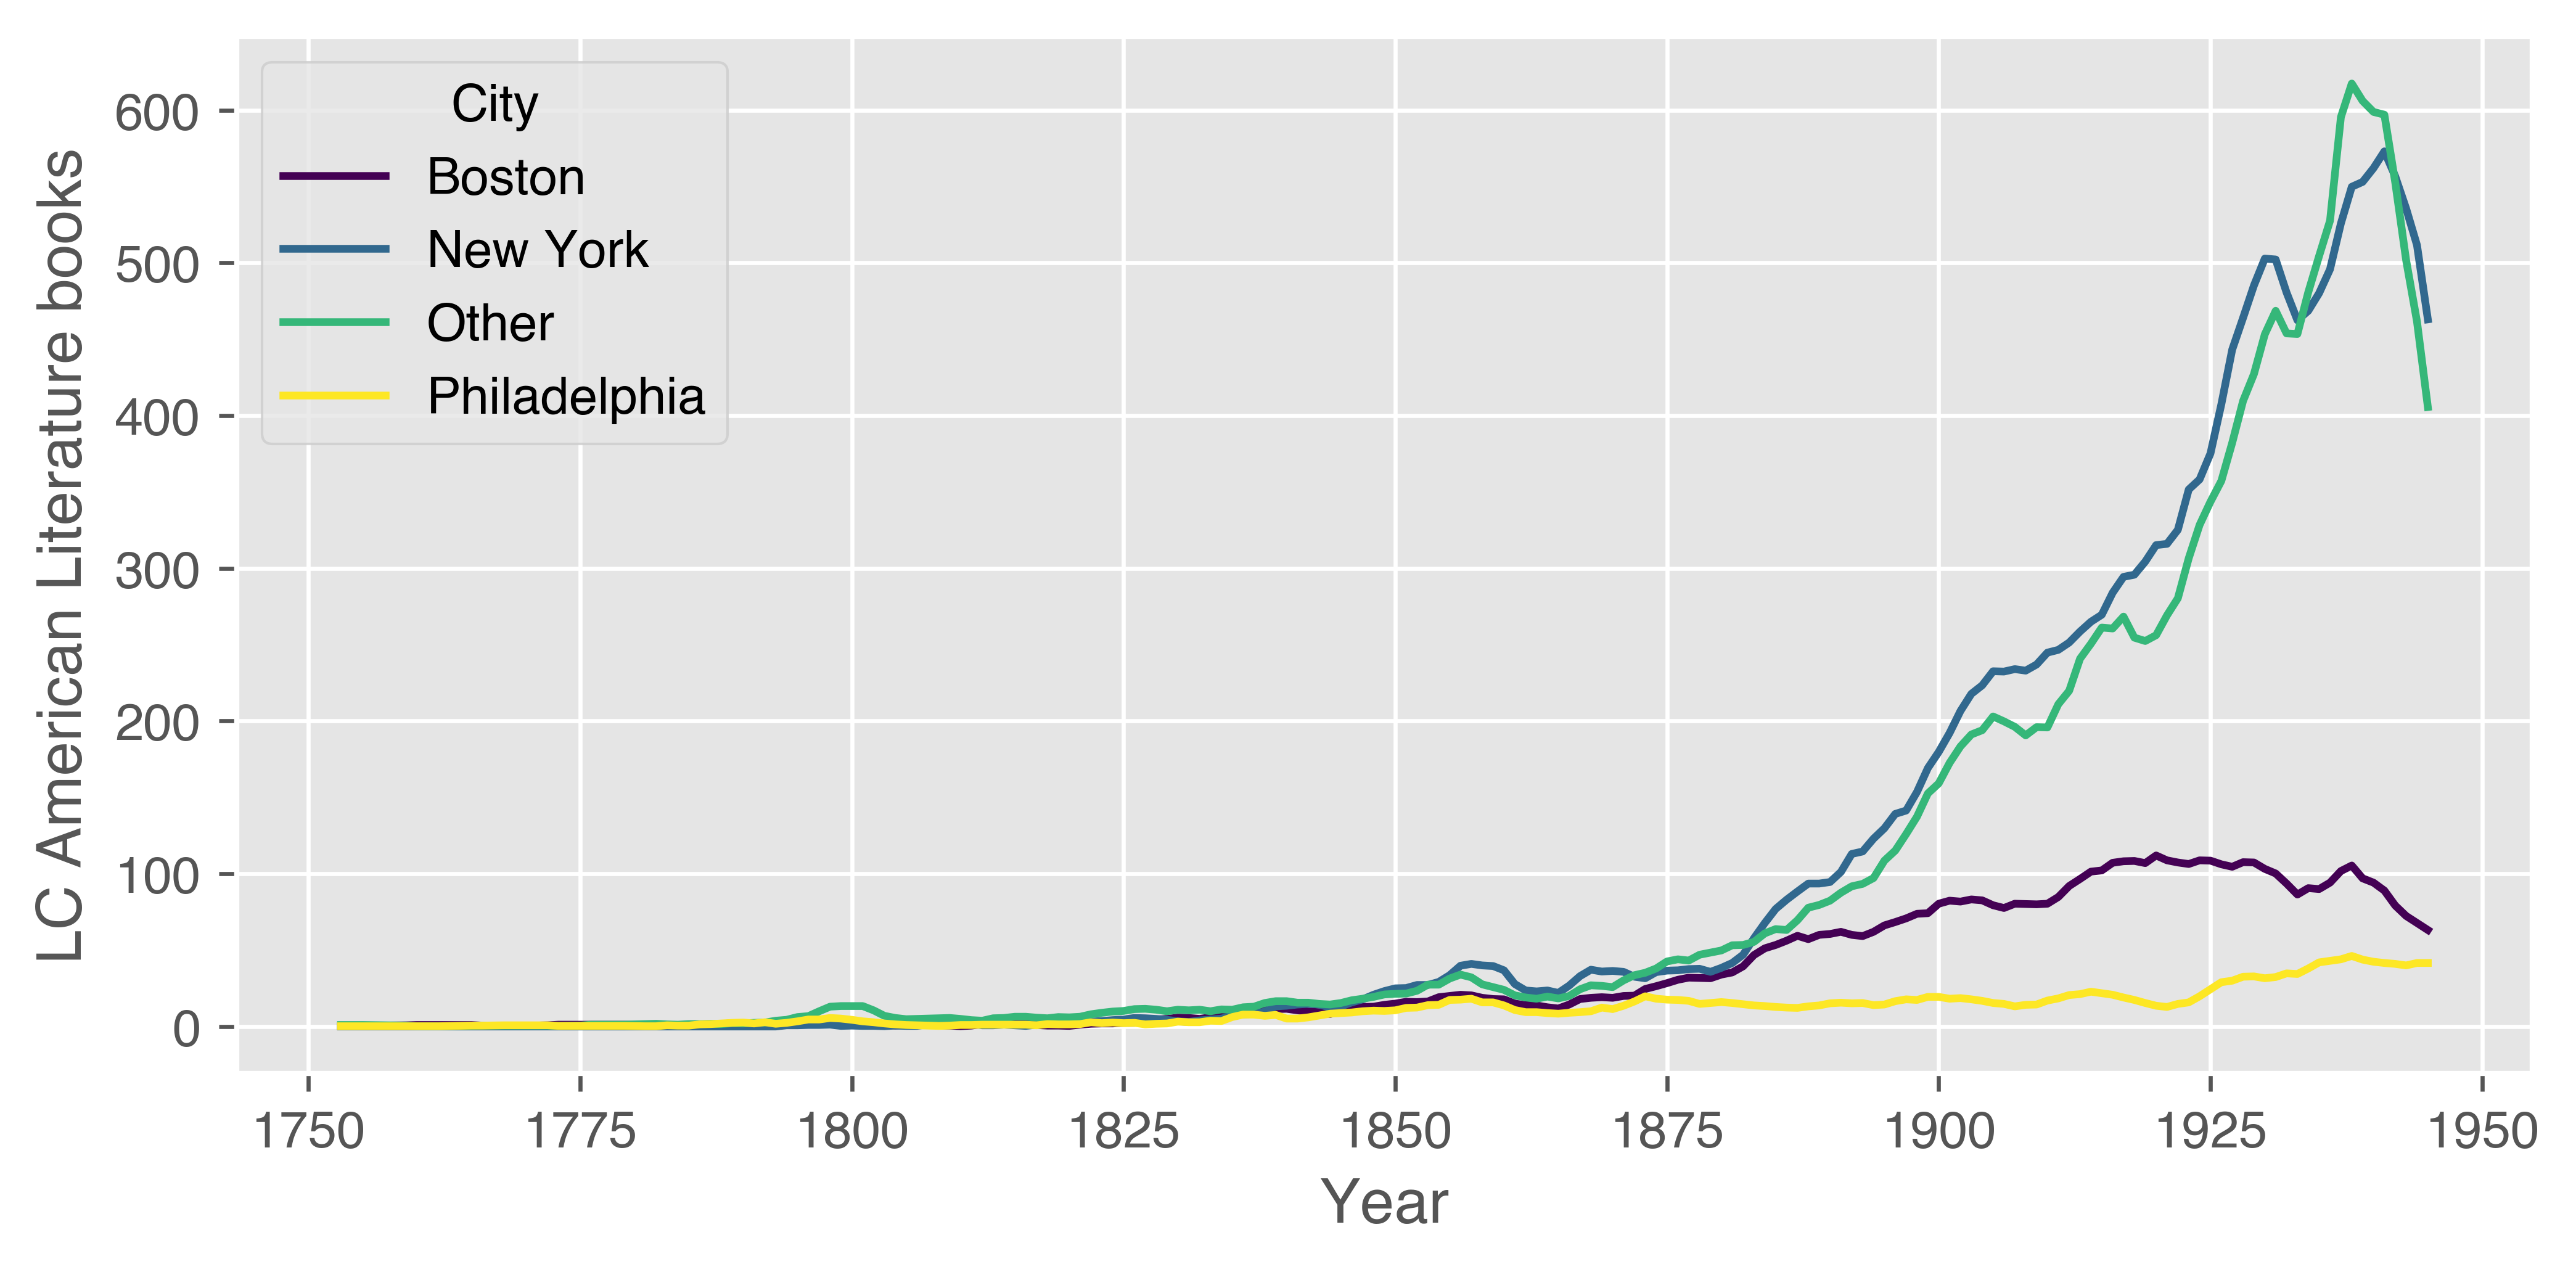

In [49]:
ax = plot_df.plot(kind="line", colormap="viridis")

ax.set_ylabel("LC American Literature books")
ax.set_xlabel("Year")
ax.legend(title="City")
ax.figure.tight_layout()
ax.figure.savefig("lc_ps_city.png", dpi=600)

In [50]:
plot_df = (
    df_exploded[(df_exploded["min_year"] >= 1800) & (df_exploded["min_year"] <= 1945)]
    .groupby(["min_year", "target_cities"])
    .size()
    .unstack()
    .fillna(0)
    .rolling(5)
    .mean()
)

In [51]:
plot_df_normed = plot_df.div(plot_df.sum(axis=1), axis=0) * 100

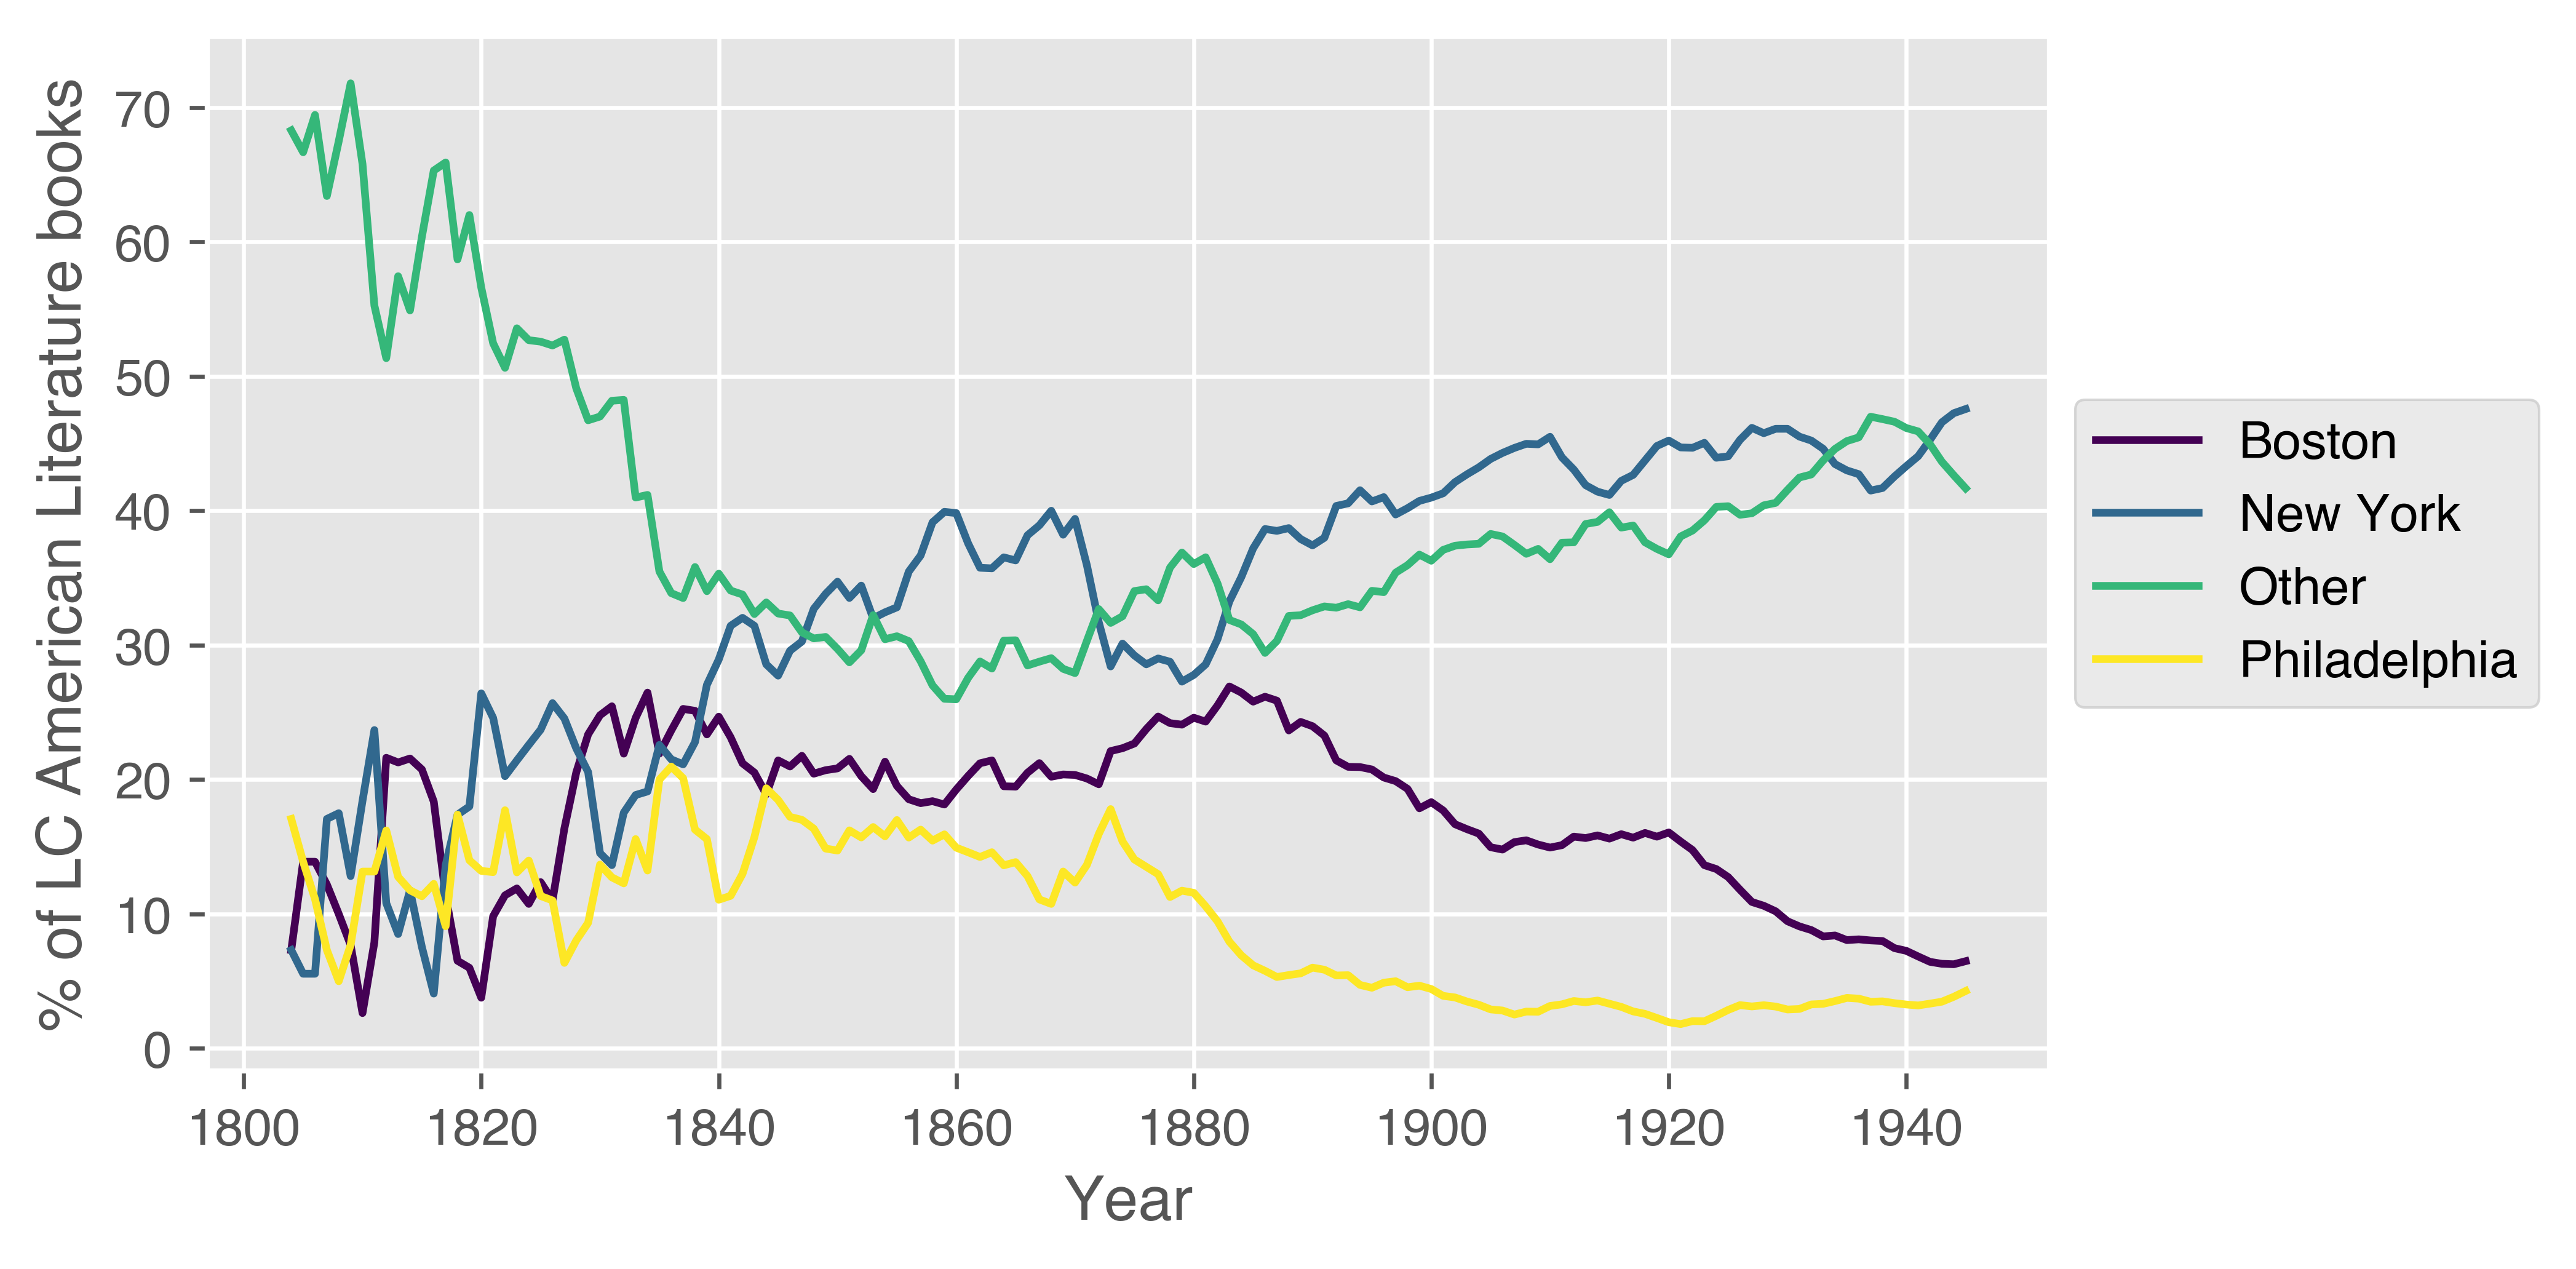

In [52]:
ax = plot_df_normed.plot(kind="line", colormap="viridis")
ax.set_ylabel("% of LC American Literature books")
ax.set_xlabel("Year")
ax.legend(title="City")
# move legend off of plot
ax.legend(loc="center left", bbox_to_anchor=(1, 0.5))
ax.figure.tight_layout()
ax.figure.savefig("lc_city_year_normed.png", dpi=600)

# What's in "Other?"

In [57]:
other = df_exploded[
    (df_exploded["min_year"] >= 1745)
    & (df_exploded["min_year"] <= 1945)
    & (df_exploded["target_cities"] == "Other")
]
other["places_clean"].value_counts().head(10)

places_clean
London                3857
Chicago               1563
Los Angeles, Calif     818
Garden City, N.Y       804
Indianapolis           598
San Francisco          291
Toronto                284
Cincinnati             278
Dallas, Tex            245
Los Angeles            210
Name: count, dtype: int64